# Problem Set 8
## Daniel Tracht

## Question 1

In this question, we want to use the data file from `Biden.csv` to investigate how different factors affect attitudes towards Joe Biden.  We can begin by importing the data:

In [22]:
import pandas as pd

biden = pd.read_csv('Biden.csv', sep=',')

### Part a
After spliting the data into a training set and test set with `random_state=25`, we want to use recursive binary splitting to fit a decision tree to the training data, with `biden` as the response variable and the others as the predictors with the options as described in the problem.


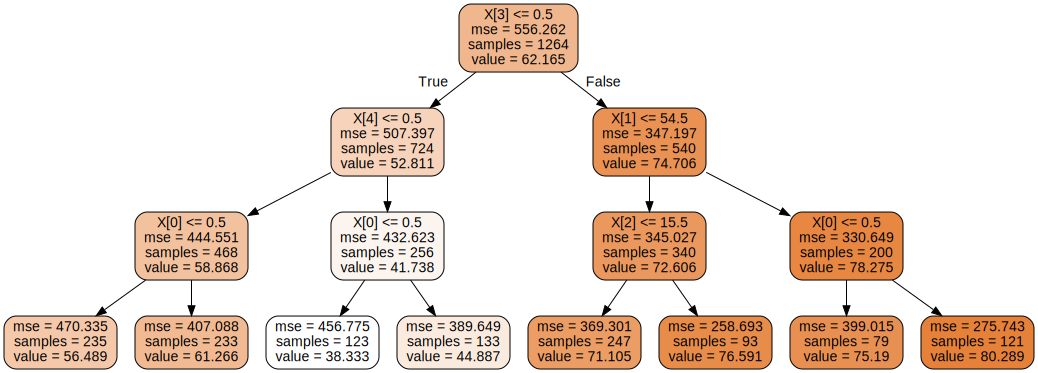

In [23]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.tree import export_graphviz
import graphviz

# Define the needed variables for this analysis
X = biden[["female", "age", "educ", "dem", "rep"]].values
y = biden["biden"].values

# Divide the data into 70% training and 30% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30,
                                                    random_state = 25)
biden_tree = DecisionTreeRegressor(max_depth=3, min_samples_leaf=5)
biden_tree.fit(X_train, y_train)

biden_tree_viz = export_graphviz(
    biden_tree,
    out_file=None,
    rounded=True,
    filled=True,
)

graph = graphviz.Source(biden_tree_viz)
graph.render('biden_tree_viz')
graph

From the first node, we have whether someone is a Democrat or not as being the first split.  On the left branch, labeled "true", we have those who have less than 0.5 for the dummy for being a Democrat and so are not Democrats.  For those who are not Democrats, the next test is if they are a Republican or not, though both responses lead to branches that use whether or not the respondent is female.

On the right branch, we have those who are Democrats.  The next test is the age of respondent, with the cutoff of 54.5 years.  Those who are less than that age and divided by their years of education, with the cutoff of 15.5 years.  Those who are older than 54.5 years are divided by whether or not they are female.

Looking towards the test data:

In [24]:
from sklearn.metrics import mean_squared_error

y_pred = biden_tree.predict(X_test)
MSE1 = mean_squared_error(y_test, y_pred)
print("Test MSE=", MSE1)

Test MSE= 396.1937146321307


### Part b
In this part we want to tune the hyperparameters in the previous method using cross validation, and report the best set of hyperparameters and the average MSE.

In [25]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint

# setting the parameter distributions over which we test as instructed
param_dist1 = {'max_depth': [3, 10],
               'min_samples_split': sp_randint(2, 20),
               'min_samples_leaf': sp_randint(2, 20)}

biden_tree2 = DecisionTreeRegressor()

random_search = \
    RandomizedSearchCV(biden_tree2, param_distributions=param_dist1,
                       n_iter=100, n_jobs=-1, cv=5, random_state=25,
                       scoring='neg_mean_squared_error')

random_search.fit(X, y)
print("Best hyperparameters: ", random_search.best_params_)
print("MSE from best hyperparameters: ", -random_search.best_score_)

Best hyperparameters:  {'max_depth': 3, 'min_samples_leaf': 17, 'min_samples_split': 14}
MSE from best hyperparameters:  401.6903602232667


### Part c
In this part, we want to tune the parameters of a Random Forest regression model on the same set of data, and report the best set of hyperparameters and the average MSE.

In [26]:
from sklearn.ensemble import RandomForestRegressor

# setting the parameter distributions over which we test as instructed
param_dist2 = {'n_estimators': [10,200],
              'max_depth': [3,10],
              'min_samples_split': sp_randint(2, 20),
              'min_samples_leaf': sp_randint(2, 20),
              'max_features': sp_randint(1, 5)}

biden_tree3 = RandomForestRegressor()

random_search2 = RandomizedSearchCV(biden_tree3,
                                    param_distributions=param_dist2,
                                    n_iter=100,
                                    n_jobs=-1,
                                    cv=5,
                                    random_state=25,
                                   scoring='neg_mean_squared_error')

random_search2.fit(X, y)
print("Best hyperparameters: ", random_search2.best_params_)
print("MSE from best hyperparameters: ", -random_search2.best_score_)

Best hyperparameters:  {'max_depth': 3, 'max_features': 3, 'min_samples_leaf': 13, 'min_samples_split': 16, 'n_estimators': 200}
MSE from best hyperparameters:  396.67193863137044


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


## Problem 2
In this problem, we will be using the `Autos` data as in Problem Set 6, making several binary variables, and running a horserace on several of the methods we have used thus far in our class

In [27]:
# Reading in the data
autos = pd.read_csv('Auto.csv', na_values="?")

# We have to make some dummies first
origins = pd.get_dummies(autos["origin"], drop_first=False)
autos = pd.concat([autos, origins], axis=1)
autos.rename(columns={1: "orgn1", 2: "orgn2"}, inplace=True)

# Creating our binary variable of interest
# find median of column
median_mpg = autos["mpg"].median()
# begin new variable at 0
autos["mpg_high"] = 0
# replace values for which mpg is greater than the median
autos.loc[(autos["mpg"] > median_mpg), "mpg_high"] = 1

# Dropping na values for logit analysis
autos.dropna(inplace=True)

# Renaming columns to desired names
autos.rename(columns={"cylinders": "cyl", "displacement": "dspl",
                      "horsepower" : "hpwr", "weight" : "wgt",
                      "acceleration" : "accl", "year" : "yr", "origin" : "orgn"}, inplace=True)

# Defining our values of interest
X = autos[["cyl", "dspl", "hpwr", "wgt", "accl", "yr", "orgn1", "orgn2"]].values
y = autos["mpg_high"].values

num_obs = X.shape[0]
const_vec = np.ones(num_obs).reshape((num_obs, 1))
# Will need to take out constant for subsequence problems
X = np.hstack((const_vec, X))

### Part a
We begin with a logistic regressions

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix

# using code as specified in problem set
kf_log = KFold(n_splits=4, shuffle=True, random_state=25)
kf_log.get_n_splits(X)

MSE_kf = np.zeros(4)

# initializing for precision metrics
c1_pred = 0
c2_pred = 0
c3_pred = 0

c1_wrong = 0
c2_wrong = 0
c3_wrong = 0

In [29]:
k_ind = int(0)
for train_index, test_index in kf_log.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    LogReg = LogisticRegression(random_state=25, solver="lbfgs", max_iter=1500)
    LogReg.fit(X_train, y_train)
    y_pred = LogReg.predict(X_test)
    MSE_kf[k_ind] = ((y_test != y_pred) ** 2).mean()
    # updating precision counts
    raveled = confusion_matrix(y_test, y_pred).ravel()
    c1_pred = c1_pred+raveled[0]+raveled[2]
    c1_wrong = c1_wrong+raveled[2]
    c2_pred = c2_pred+raveled[1]+raveled[3]
    c2_wrong = c2_wrong+raveled[1]
    k_ind += 1
print("MPG_high=0 error rate:", c1_wrong/c1_pred)
print("MPG_high=1 error rate:", c2_wrong/c2_pred)
print('Mean MSE across all k-Fold tests=', MSE_kf.mean())

MPG_high=0 error rate: 0.08717948717948718
MPG_high=1 error rate: 0.13705583756345177
Mean MSE across all k-Fold tests= 0.11224489795918366


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


### Part b
Next, we wish to use a RandomForest method

In [30]:
# need data without the constant
X = autos[["cyl", "dspl", "hpwr", "wgt", "accl", "yr", "orgn1", "orgn2"]].values
y = autos["mpg_high"].values

# setting the parameter distributions over which we test as instructed
param_dist3 = {'n_estimators': [10,200],
              'max_depth': [3,8],
              'min_samples_split': sp_randint(2, 20),
              'min_samples_leaf': sp_randint(2, 20),
              'max_features': sp_randint(1, 8)}

auto_tree1 = RandomForestRegressor()

random_search3 = RandomizedSearchCV(auto_tree1,
                                    param_distributions=param_dist3,
                                    n_iter=100,
                                    n_jobs=-1,
                                    cv=4,
                                    random_state=25,
                                   scoring='neg_mean_squared_error')
random_search3.fit(X, y)
print("Best hyperparameters for Random Forest: ", random_search3.best_params_)
print("MSE from best hyperparameters for Random Forest: ", -random_search3.best_score_)

Best hyperparameters for Random Forest:  {'max_depth': 8, 'max_features': 1, 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 10}
MSE from best hyperparameters for Random Forest:  0.1001790089570425


### Part c
Finally, we want to use a SVM model

In [21]:
from sklearn import svm
from scipy.stats import uniform as sp_uniform

# From the documentation, shrinking needs to be a Boolean, not a string as in the problem set
# Quite confusingly, the error says just that something in my fit commmand needs to be an integer
# This was a nasty bug
param_dist4 = {'C': sp_uniform(loc=0.2, scale=4.0),
              'gamma': ['scale', 'auto'],
              'shrinking': [True, False]}

# kernel='rbf' is the default
auto_svm = svm.SVC()

random_search4 = RandomizedSearchCV(auto_svm,
                                    param_distributions=param_dist4,
                                    n_iter=100,
                                    n_jobs=-1,
                                    cv=4,
                                    random_state=25,
                                   scoring='neg_mean_squared_error')
random_search4.fit(X, y)
print("Best hyperparameters for SVM: ", random_search4.best_params_)
print("MSE from best hyperparameters SVM: ", -random_search4.best_score_)

Best hyperparameters for SVM:  {'C': 1.504204504551302, 'gamma': 'scale', 'shrinking': True}
MSE from best hyperparameters SVM:  0.12244897959183673


From the above three models, it seems that our RandomForest classifier has the lowest MSE.  This is not entirely surprisingly given its asymmetric features across branches.